# Mapping precipitation data with geopandas

In this notebook, we explore one of the datasets from the Climate Prediction Center, and attempt to map mean monthly precipitations from the years 1990 to 2021 <br>
Source of data: https://psl.noaa.gov/data/gridded/data.cmap.html#detail

--------------------

## Creating the gridded monthly precipitations (mean) dataset
Since the file formats are in .netcdf4 format (N-Dimensional gridded data), we resort to xarray, which integrates dask for parallel computing and faster processing

In [227]:
!pip install netcdf4 scipy cfgrib h5netcdf zarr h5pyd xarray h5netcdf pyspark dask toolz pydap dask crick fsspec aiohttp cdsapi
!pip install eccodes==1.2.0
!pip install pyeccodes libeccodes.so libeccodes
!pip install psycopg2-binary
!pip install global_land_mask

In [214]:
# for processing data:
import netCDF4
import numpy as np
import os
import pandas as pd
import time
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

# for mapping data:
%matplotlib inline
import geopandas
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify
from global_land_mask import globe # for determining coordinates at ocean/land

In [228]:
from global_land_mask import globe

In [6]:
# importing CPC dataset of daily max temperatures

url = 'https://downloads.psl.noaa.gov/Datasets/cmap/std/precip.mon.mean.nc'
fs = HTTPFileSystem() 
fobj = fs.open(url)

xr_noaa = xr.open_dataset(fobj, chunks={'lat':360, 'lon':720})

C:\Users\ncozz\anaconda3\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [7]:
xr_noaa

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 516)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(516, 72, 144), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2201
    history:        update 01/2022 V2201
    data_modified:  2022-01-10

In [196]:
# creating pandas dataframe frop the NETCDF dataset:
df_noaa = xr_noaa.to_dataframe()
prec_df = df_noaa.dropna().reset_index()

In [197]:
prec_df

,lat,lon,time,precip
0,88.75,1.25,1997-06-01,0.20
1,88.75,3.75,1997-06-01,6.30
2,88.75,6.25,1997-06-01,8.35
3,88.75,13.75,1997-06-01,8.94
4,88.75,23.75,1997-06-01,2.62
...,...,...,...,...
4978522,-88.75,358.75,2021-08-01,0.00
4978523,-88.75,358.75,2021-09-01,0.21
4978524,-88.75,358.75,2021-10-01,0.26
4978525,-88.75,358.75,2021-11-01,0.18


In [208]:
# column for year of observation
prec_df['year'] = pd.DatetimeIndex(prec_df['time']).year
prec_count = prec_df

In [209]:
prec_count

,lat,lon,time,precip,year
0,88.75,1.25,1997-06-01,0.20,1997
1,88.75,3.75,1997-06-01,6.30,1997
2,88.75,6.25,1997-06-01,8.35,1997
3,88.75,13.75,1997-06-01,8.94,1997
4,88.75,23.75,1997-06-01,2.62,1997
...,...,...,...,...,...
4978522,-88.75,358.75,2021-08-01,0.00,2021
4978523,-88.75,358.75,2021-09-01,0.21,2021
4978524,-88.75,358.75,2021-10-01,0.26,2021
4978525,-88.75,358.75,2021-11-01,0.18,2021


In [211]:
# pairs of latitude and longitude pairs where there are missing observations for any year before 1990:
pairsdrop = prec_count.groupby(['lat','lon'])['year'].min().reset_index()
pairsdrop = pairsdrop[pairsdrop.year>1990].iloc[:,0:2]
pairsdrop = pairsdrop.to_records(index=False)

# set condition:
condition = pd.Series(list(zip(prec_count.lat, prec_count.lon))).isin(pairsdrop)
# drop pairs of latitude and longitude with missing values for some year >=2000
prec_count = prec_count[~condition]

In [212]:
prec_count

,lat,lon,time,precip,year
48,86.25,1.25,1979-02-01,0.66,1979
49,86.25,1.25,1979-03-01,0.00,1979
50,86.25,1.25,1979-04-01,0.36,1979
51,86.25,1.25,1979-05-01,0.24,1979
52,86.25,1.25,1979-06-01,0.41,1979
...,...,...,...,...,...
4978522,-88.75,358.75,2021-08-01,0.00,2021
4978523,-88.75,358.75,2021-09-01,0.21,2021
4978524,-88.75,358.75,2021-10-01,0.26,2021
4978525,-88.75,358.75,2021-11-01,0.18,2021


In [231]:
#create dataframe with mean monthly precipitation:
prec_count = prec_count[prec_df.year >= 1990] # dropping years before 1990
plot_df = prec_count.groupby(['lon','lat'])["precip"].mean().to_frame().reset_index()
plot_df

C:\Users\ncozz\AppData\Local\Temp/ipykernel_11720/534859100.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prec_count = prec_count[prec_df.year >= 1990] # dropping years before 1990


,lon,lat,precip
0,1.25,-88.75,0.566849
1,1.25,-86.25,0.654141
2,1.25,-83.75,0.694922
3,1.25,-81.25,0.736094
4,1.25,-78.75,0.707031
...,...,...,...
9567,358.75,73.75,0.360417
9568,358.75,76.25,0.265599
9569,358.75,78.75,0.662682
9570,358.75,83.75,0.370521


-------------
## Mapping precipitation data with geopandas:

In [251]:
# for geopandas, we must transform the longitudes from a range of (0, 360) to (-180, 180)
precipitations = plot_df
precipitations.lon = (precipitations.lon + 180) % 360 - 180

In [253]:
# let us first drop coordinates in the ocean, since they could skew the range and make most 'land' values low
pairsdrop = precipitations[['lat','lon']].to_records(index=False)
condition = []
for x in pairsdrop: condition.append(globe.is_land(x.lat, x.lon))

precipitations = precipitations[condition]

In [269]:
precipitations.precip.var()

2.0502536296844482

In [254]:
# now, for the fun part, let's create the plot with the remaining coordinates:

%matplotlib inline
map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)

geometry = geopandas.points_from_xy(precipitations.lon, precipitations.lat)
geo_df = geopandas.GeoDataFrame(precipitations, geometry=geometry)

Text(0.5, 1.0, 'Mean monthly precipitations, 1990-2021 (total value)')

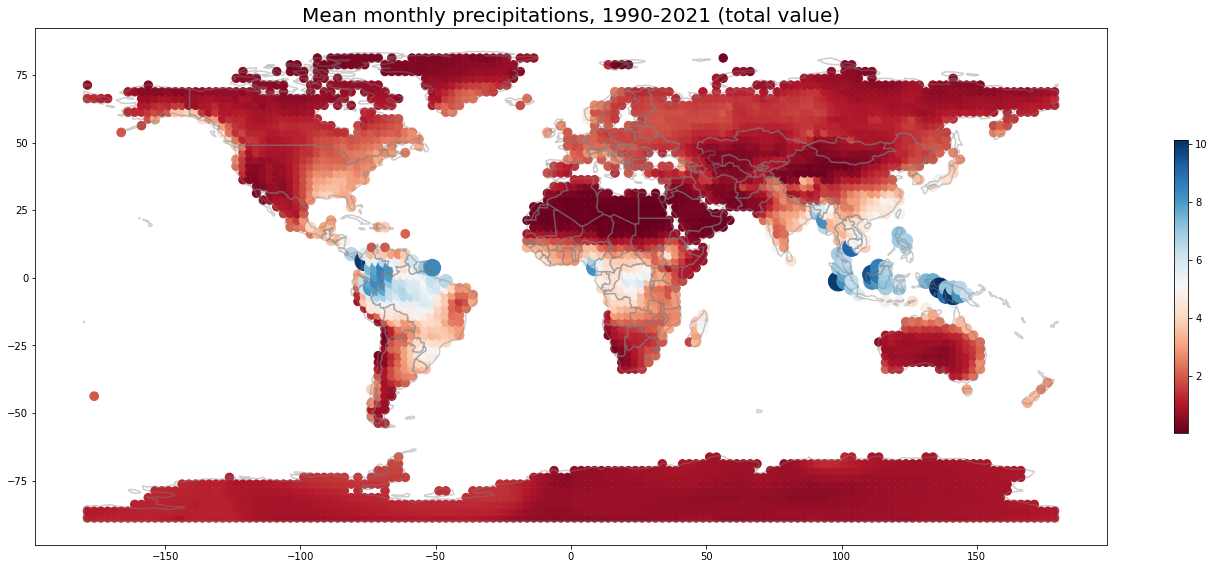

In [312]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(24,18))
world.boundary.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='precip', ax=ax, cmap='RdBu', 
            markersize=(precipitations.precip)**2.5+70,
            legend_kwds={'shrink': 0.3},
            legend=True)
plt.title('Mean monthly precipitations, 1990-2021 (total value)', fontdict={'fontsize':20})

Text(0.5, 1.0, 'Mean monthly precipitations, 1990-2021 (quantile-based)')

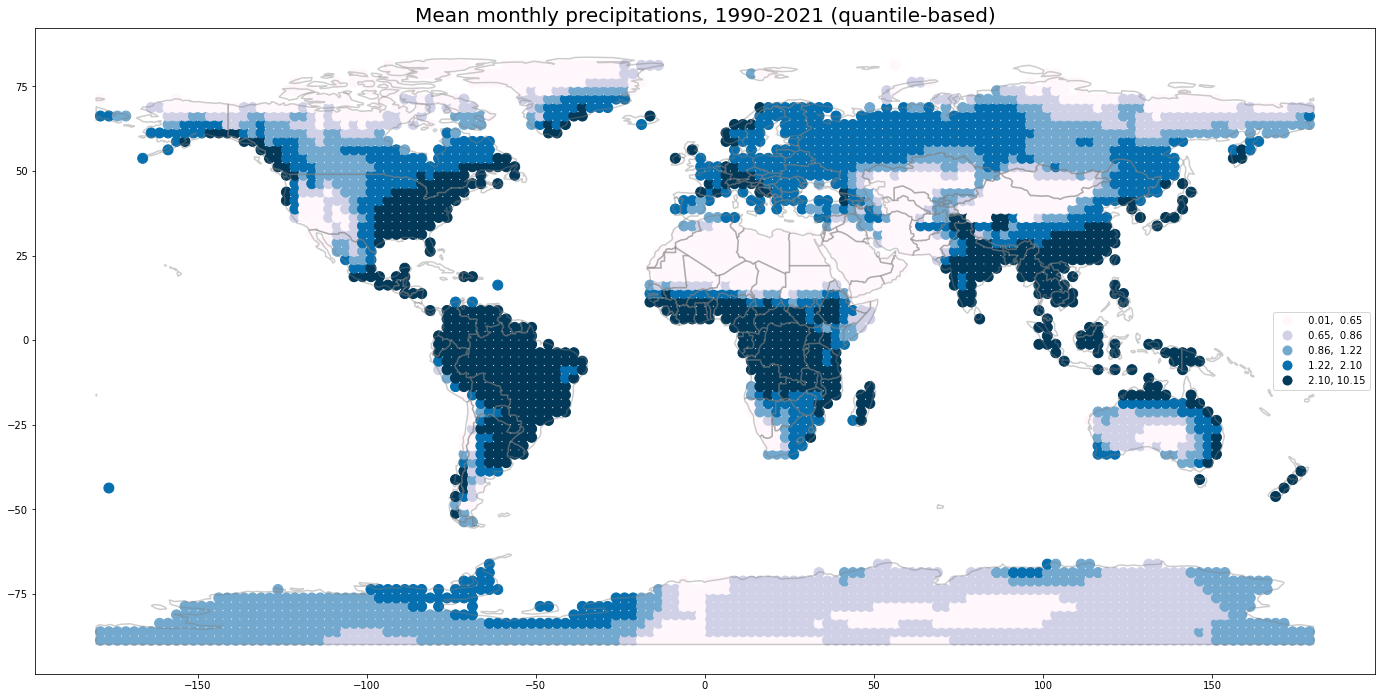

In [311]:
# for quantilesÑ

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(24,18))
world.boundary.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='precip', ax=ax, cmap='PuBu', 
            scheme='quantiles',
            markersize=100,
            # legend_kwds={'shrink': 0.3},
            legend=True)
plt.title('Mean monthly precipitations, 1990-2021 (quantile-based)', fontdict={'fontsize':20})